In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [2]:
x = torch.linspace(0, 799, 800)

In [4]:
y = torch.sin(x*2*3.1416/40)

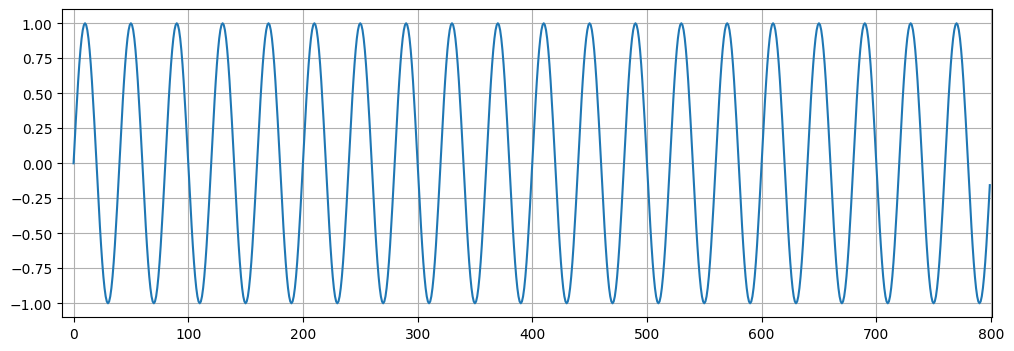

In [8]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

In [10]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

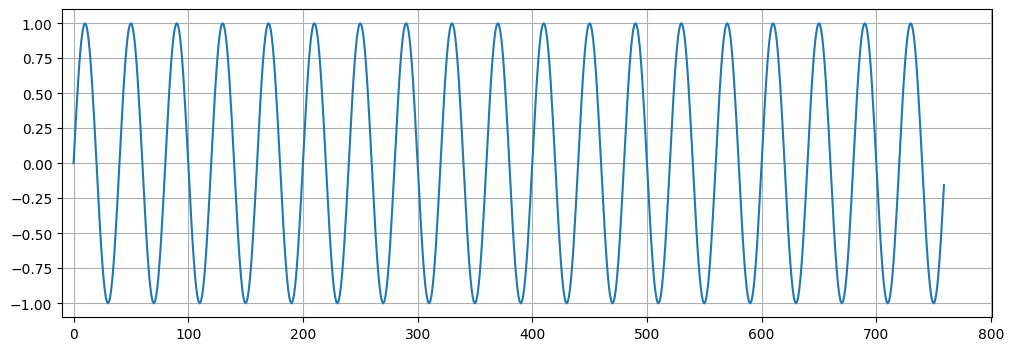

In [11]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set.numpy())

In [13]:
def input_data(seq, ws):

    out = [] # ([0,1,2,3], [4]), ([1,2,3,4], [5]) ....
    L = len(seq)

    for i in range(L - ws):
        window = seq[i: i+ws]
        label = seq[i+ws: i+ws+1]
        out.append((window, label))

    return out

In [15]:
window_size = 40

train_data = input_data(train_set, window_size)

In [16]:
len(train_data)

720

In [18]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [19]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

### Model

In [21]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, out_size=1):

        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, out_size)

        # (H, C)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):

        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        pred = self.linear(lstm_out.view(len(seq), -1))

        return pred[-1]


In [22]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [25]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


### Training

Epoch 0 Loss: 0.09212878346443176
Performance on test range: 0.6071590185165405


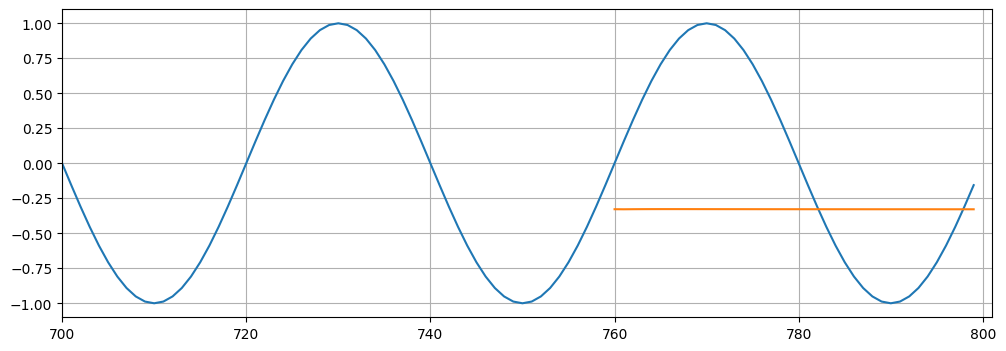

Epoch 1 Loss: 0.06506765633821487
Performance on test range: 0.5650986433029175


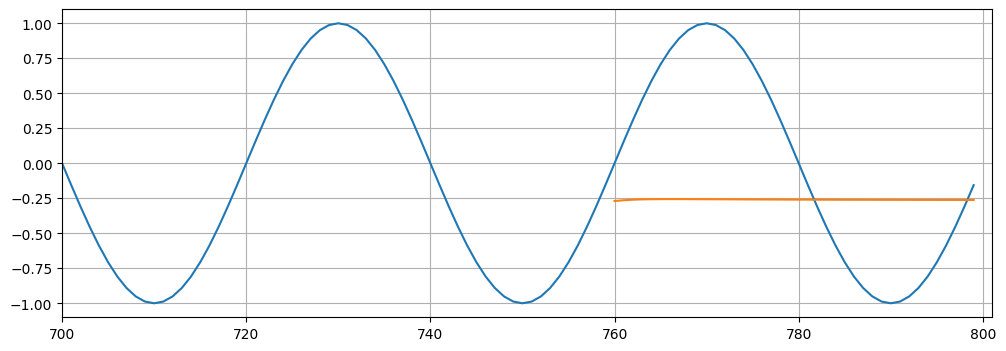

Epoch 2 Loss: 0.04198049008846283
Performance on test range: 0.5199716687202454


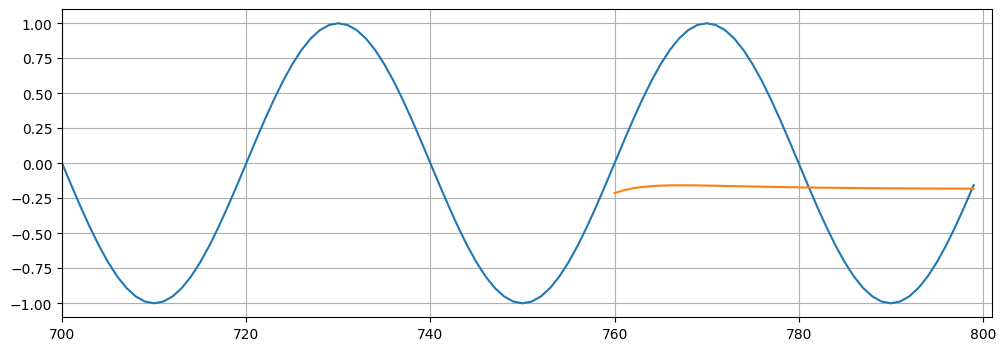

Epoch 3 Loss: 0.017842764034867287
Performance on test range: 0.42209964990615845


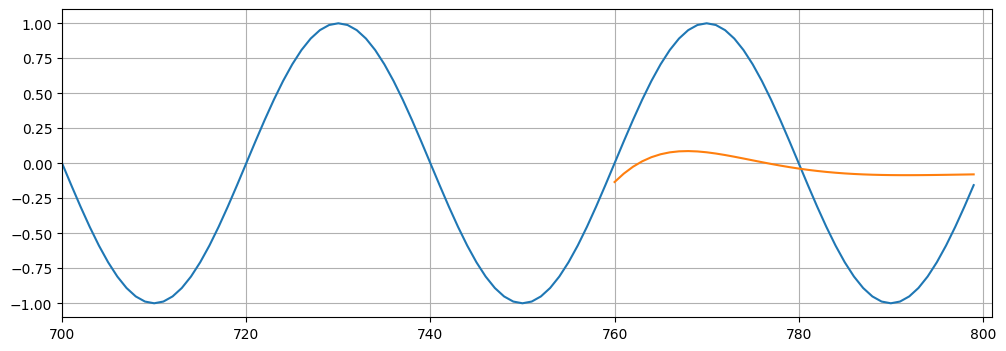

Epoch 4 Loss: 0.0028871013782918453
Performance on test range: 0.16624097526073456


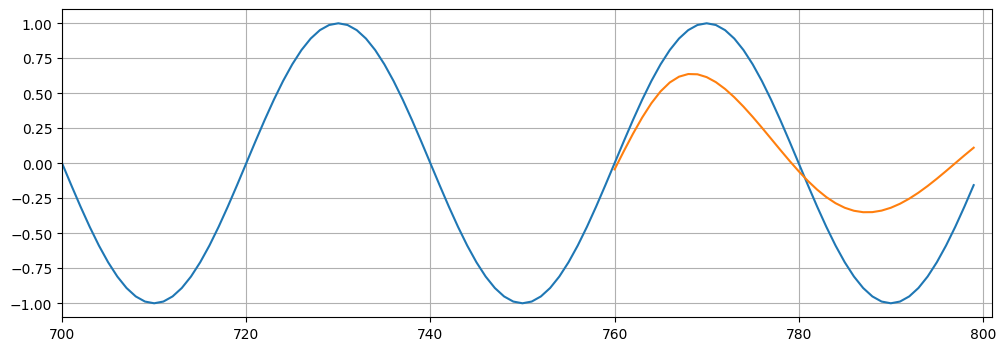

Epoch 5 Loss: 0.00032007633126340806
Performance on test range: 0.03055441938340664


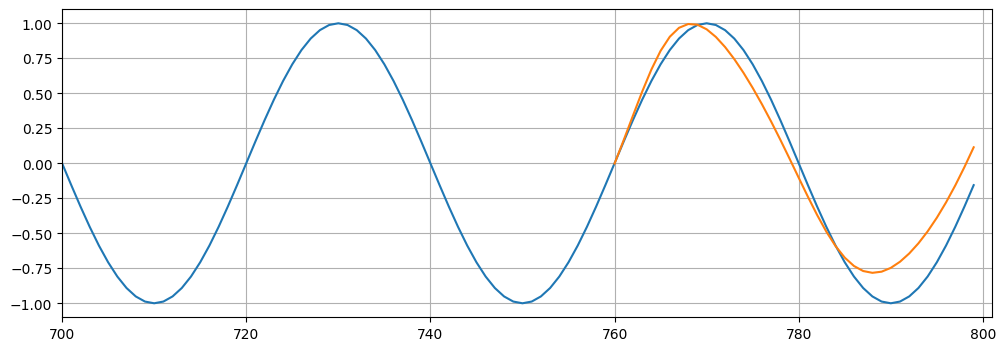

Epoch 6 Loss: 0.0001296920672757551
Performance on test range: 0.014990149065852165


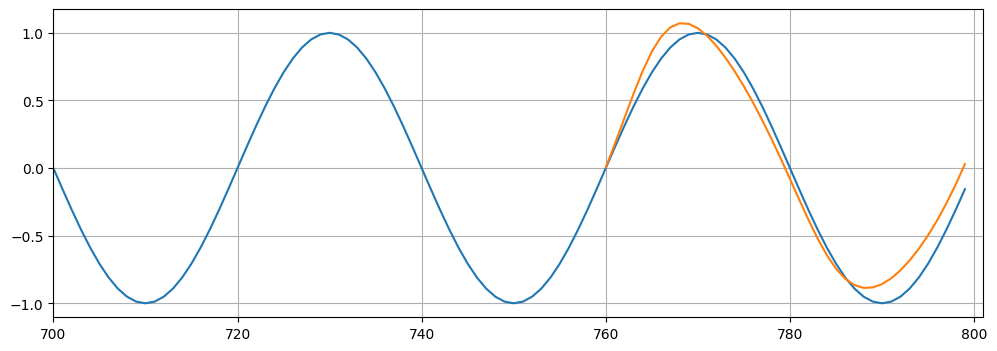

Epoch 7 Loss: 0.00012006635370198637
Performance on test range: 0.011856687255203724


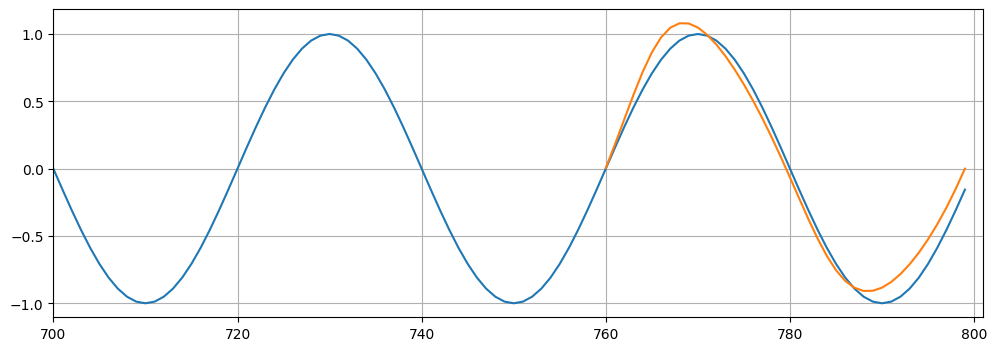

Epoch 8 Loss: 0.00012655690079554915
Performance on test range: 0.010163826867938042


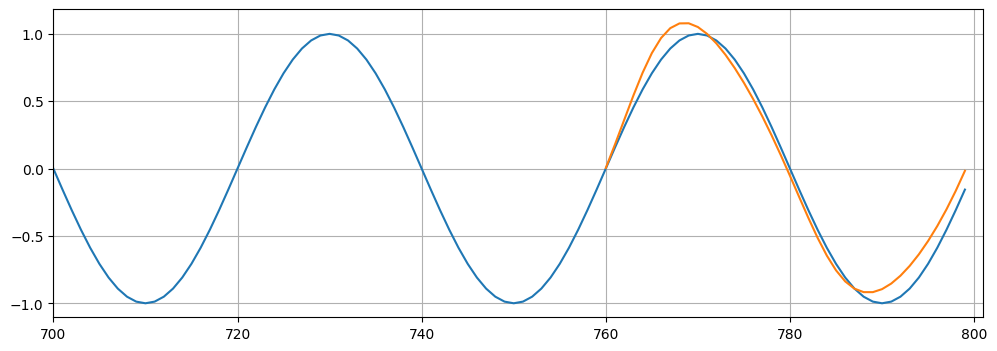

Epoch 9 Loss: 0.00013195440988056362
Performance on test range: 0.008897571824491024


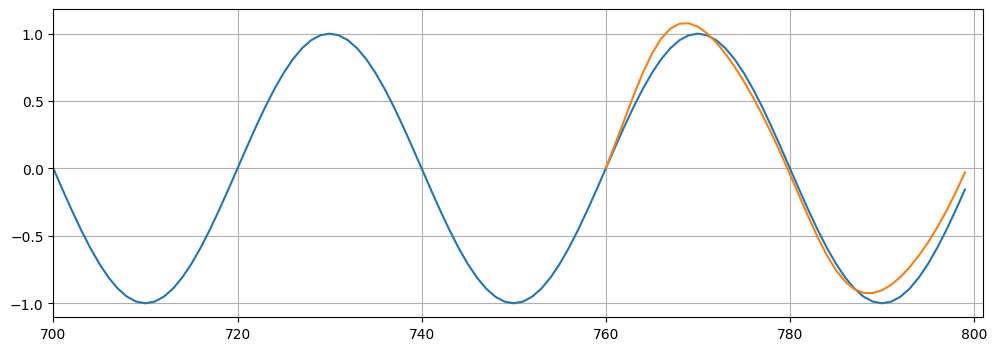

In [28]:
epochs = 10
future = 40

for i in range(epochs):

    for seq, y_train in train_data:

        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")

    preds = train_set[-window_size:].tolist()

    for f in range(future):

        seq = torch.FloatTensor(preds[-window_size:])

        with torch.no_grad():

            model.hidden = (torch.zeros(1,1,model.hidden_size), 
                            torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())

    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")

    plt.figure(figsize=(12,4))
    plt.xlim(700, 801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760, 800), preds[window_size:]) 
    plt.show()      

In [30]:
epochs = 15
window_size = 40
future = 40

all_data = input_data(y, window_size)
len(all_data)

760

In [31]:
import time
start_time = time.time()

for i in range(epochs):

    for seq, y_train in train_data:

        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")


total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss: 0.00013450371625367552
Epoch 1 Loss: 0.00013458322791848332
Epoch 2 Loss: 0.00013279310951475054
Epoch 3 Loss: 0.00012966558279003948
Epoch 4 Loss: 0.00012561386392917484
Epoch 5 Loss: 0.00012097525177523494
Epoch 6 Loss: 0.00011599595745792612
Epoch 7 Loss: 0.00011086133599746972
Epoch 8 Loss: 0.00010570869199000299
Epoch 9 Loss: 0.00010062992805615067
Epoch 10 Loss: 9.569717076374218e-05
Epoch 11 Loss: 9.094690904021263e-05
Epoch 12 Loss: 8.641256863484159e-05
Epoch 13 Loss: 8.210835949284956e-05
Epoch 14 Loss: 7.803594780853018e-05
0.09329069852828979


### Forecat Into Unknown Future

In [32]:
preds = y[-window_size:].tolist()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

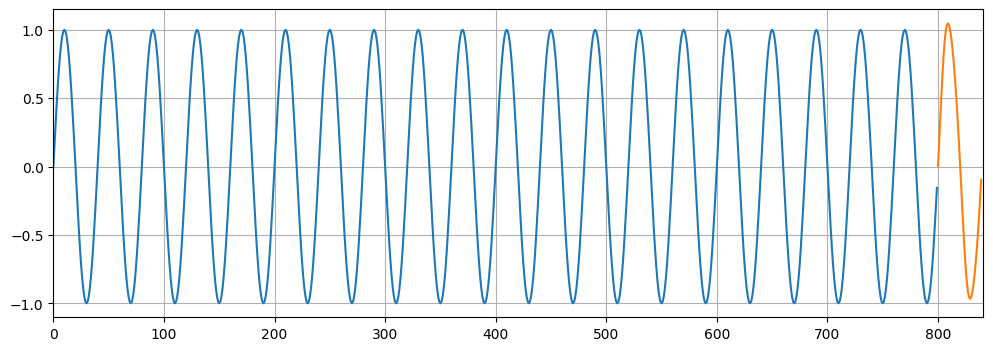

In [33]:
plt.figure(figsize=(12,4))
plt.xlim(0, 841)
plt.grid(True)
plt.plot(y.numpy())

# Plotting Forecast
plt.plot(range(800, 800+future), preds[window_size:])
plt.show()